In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os
import seaborn as sns
import datetime as datetime

# Solar Output Prediction using PyTorch Artificial Neural Network

This notebook implements a simple feedforward neural network using PyTorch to predict PV(W) - Solar Output.
Based on the approach used in `big_project_KAN.ipynb`.

In [20]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
MODEL_DIR = f'{HOME_DIR}/model/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'

# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [21]:
hourly_nightly_threshold = 50

In [22]:
df_merge_hourly = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_full_data.feather")

# Remove all rows where Clear sky GHI is less than or equal to 50
df_merge_hourly = df_merge_hourly[df_merge_hourly['Clear sky GHI'] > hourly_nightly_threshold]

print(f"Data loaded: {df_merge_hourly.shape[0]} rows, {df_merge_hourly.shape[1]} columns")

Data loaded: 4386 rows, 69 columns


In [23]:
level1_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_merge_hourly.columns.tolist() if level.startswith('level2_')]

print(f"Level 1 features: {len(level1_features)}")
print(f"Level 2 features: {len(level2_features)}")

Level 1 features: 15
Level 2 features: 5


In [27]:
# Define target column
target_col = 'PV(W)'

# Define features - same as KAN notebook
feature_cols = []
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
feature_cols.append('Wind Cooling')
feature_cols.append('Power_ClearSky_Pane_I(W)')
feature_cols.append('Power_ClearSky_Pane_II(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
feature_cols.append('Month_Cos')
feature_cols.append('DayOfYear_Cos')
feature_cols.append('HourOfDay_Cos')
feature_cols += level2_features

print(f"\nTarget: {target_col}")
print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")


Target: PV(W)
Number of features: 24
Features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'Month_Cos', 'DayOfYear_Cos', 'HourOfDay_Cos', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [29]:
# Validate that all required features exist in the dataframe
missing_features = [col for col in feature_cols if col not in df_merge_hourly.columns]
if missing_features:
    print(f"Warning: The following features are missing from the dataset: {missing_features}")
    print("Removing missing features from feature list...")
    feature_cols = [col for col in feature_cols if col in df_merge_hourly.columns]

if target_col not in df_merge_hourly.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset")

print(f"Using {len(feature_cols)} features for training")

# Drop NaNs
model_df = df_merge_hourly.dropna(subset=feature_cols + [target_col])
X = model_df[feature_cols].values
y = model_df[target_col].values.reshape(-1, 1)

print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")

# Normalize (Neural Networks work better with scaled data)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print("\nData prepared and converted to PyTorch tensors")


Using 24 features for training
Dataset shape: X=(4386, 24), y=(4386, 1)
Training set: X_train=(3508, 24), y_train=(3508, 1)
Test set: X_test=(878, 24), y_test=(878, 1)

Data prepared and converted to PyTorch tensors


In [44]:
class ImprovedSolarNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedSolarNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.output = nn.Linear(32, 1)
        
        self.act = nn.LeakyReLU(0.1) # Prevents dead neurons
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.dropout(self.act(self.bn1(self.layer1(x))))
        x = self.dropout(self.act(self.bn2(self.layer2(x))))
        x = self.dropout(self.act(self.bn3(self.layer3(x))))
        return self.output(x)

class SolarPredictionNN(nn.Module):
    def __init__(self, input_dim):
        super(SolarPredictionNN, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = ImprovedSolarNN(input_dim).to(device)

print(f"Model initialized with input dimension: {input_dim}")
print(f"\nModel architecture:")
print(model)

Model initialized with input dimension: 24

Model architecture:
ImprovedSolarNN(
  (layer1): Linear(in_features=24, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (act): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [56]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 200
batch_size = 64

print(f"Training configuration:")
print(f"  Loss function: MSE")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")

Training configuration:
  Loss function: MSE
  Optimizer: Adam (lr=0.001)
  Epochs: 200
  Batch size: 64


In [57]:
# Storage for loss history
train_losses = []
test_losses = []

print("Starting training...\n")

for epoch in range(num_epochs):
    model.train()
    
    # Mini-batch training
    permutation = torch.randperm(X_train_tensor.size()[0])
    epoch_loss = 0
    
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = epoch_loss / (X_train_tensor.size()[0] / batch_size)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        test_losses.append(test_loss)
    
    # Print progress
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}")

print("\n✓ Training Complete!")

Starting training...

Epoch [20/200], Train Loss: 0.151741, Test Loss: 0.152326
Epoch [40/200], Train Loss: 0.142251, Test Loss: 0.151832
Epoch [60/200], Train Loss: 0.144505, Test Loss: 0.151209
Epoch [80/200], Train Loss: 0.150999, Test Loss: 0.152699
Epoch [100/200], Train Loss: 0.140940, Test Loss: 0.153020
Epoch [120/200], Train Loss: 0.153420, Test Loss: 0.154999
Epoch [140/200], Train Loss: 0.148460, Test Loss: 0.150427
Epoch [160/200], Train Loss: 0.141710, Test Loss: 0.152779
Epoch [180/200], Train Loss: 0.145762, Test Loss: 0.152917
Epoch [200/200], Train Loss: 0.136022, Test Loss: 0.150401

✓ Training Complete!


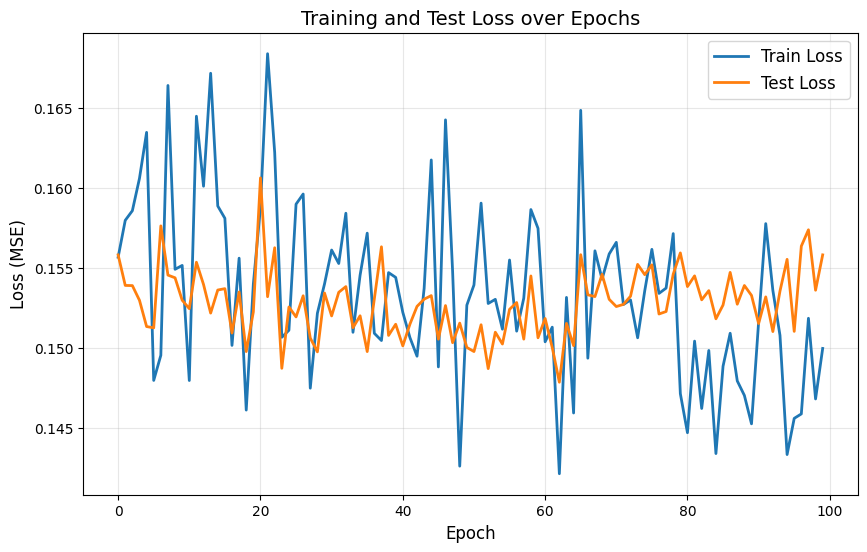

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss over Epochs', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# =========================================================# Enhanced Metrics Calculation with PV(W) Conversion# =========================================================# Helper function to calculate metricsdef calculate_metrics_for_target(y_true, y_pred, target_name="Target"):    """Calculate comprehensive metrics for predictions"""    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score    import numpy as np        mae = mean_absolute_error(y_true, y_pred)    mse = mean_squared_error(y_true, y_pred)    rmse = np.sqrt(mse)    r2 = r2_score(y_true, y_pred)        # Normalized metrics    capacity = y_true.max()    if capacity == 0:        n_mae = 0        n_rmse = 0    else:        n_mae = mae / capacity        n_rmse = rmse / capacity    accuracy = 1 - n_mae  # Simplified accuracy metric        metrics = {        'rmse': rmse,        'mae': mae,        'r2': r2,        'n_rmse': n_rmse,        'n_mae': n_mae,        'n_rmse_pct': n_rmse * 100,        'n_mae_pct': n_mae * 100,        'accuracy': accuracy    }        print(f"\n{target_name} Metrics:")    print(f"  RMSE:    {rmse:.2f}")    print(f"  MAE:     {mae:.2f}")    print(f"  R²:      {r2:.4f}")    print(f"  N-RMSE:  {n_rmse:.4f} ({n_rmse*100:.2f}%)")    print(f"  N-MAE:   {n_mae:.4f} ({n_mae*100:.2f}%)")    print(f"  Accuracy: {accuracy:.4f}")        return metricsdef convert_to_pvw(y_pred, y_true, target_col, clearsky_values):    """Convert predictions to PV(W) based on target column type"""    import numpy as np        if target_col == 'PV(W)':        # Already in PV(W), no conversion needed        return y_pred.copy(), y_true.copy()    elif target_col == 'Clearsky_Index':        # PV(W) = Clearsky_Index * Total_Power_ClearSky_Output(W)        y_pred_pvw = y_pred * clearsky_values        y_true_pvw = y_true * clearsky_values    elif target_col == 'PV(W)_error':        # PV(W) = PV(W)_error + Total_Power_ClearSky_Output(W)        y_pred_pvw = y_pred + clearsky_values        y_true_pvw = y_true + clearsky_values    elif target_col == 'PV(W)_error_index':        # PV(W) = PV(W)_error_index * Total_Power_ClearSky_Output(W) + Total_Power_ClearSky_Output(W)        y_pred_pvw = y_pred * clearsky_values + clearsky_values        y_true_pvw = y_true * clearsky_values + clearsky_values    else:        raise ValueError(f"Unknown target column: {target_col}")        # Apply physics constraints (no negative power output)    y_pred_pvw = np.clip(y_pred_pvw, 0, None)    y_true_pvw = np.clip(y_true_pvw, 0, None)        return y_pred_pvw, y_true_pvw# =========================================================# Extract clearsky values from features# =========================================================# Find the index of 'Total_Power_ClearSky_Output(W)' in feature_colsclearsky_index = feature_cols.index('Total_Power_ClearSky_Output(W)')# Extract clearsky values from test and train setsclearsky_test = X_test[:, clearsky_index].reshape(-1, 1)clearsky_train = X_train[:, clearsky_index].reshape(-1, 1)print(f"Clearsky values extracted: train={clearsky_train.shape}, test={clearsky_test.shape}")# =========================================================# Test Set Predictions and Metrics# =========================================================model.eval()with torch.no_grad():    y_pred_test_scaled = model(X_test_tensor).cpu().numpy()    y_pred_train_scaled = model(X_train_tensor).cpu().numpy()# Inverse transform to get actual valuesy_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)y_test_actual = scaler_y.inverse_transform(y_test_scaled)y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)y_train_actual = scaler_y.inverse_transform(y_train_scaled)# Apply physics constraints (no negative power output)y_pred_test = np.clip(y_pred_test, 0, None)y_test_actual = np.clip(y_test_actual, 0, None)y_pred_train = np.clip(y_pred_train, 0, None)y_train_actual = np.clip(y_train_actual, 0, None)print("\nPredictions generated and inverse-transformed")# Calculate metrics for configured target columnprint("="*60)print(f"Metrics for Configured Target: {target_col}")print("="*60)test_metrics = calculate_metrics_for_target(y_test_actual, y_pred_test, f"Test - {target_col}")train_metrics = calculate_metrics_for_target(y_train_actual, y_pred_train, f"Train - {target_col}")# =========================================================# Convert to PV(W) and Calculate PV(W) Metrics# =========================================================print("\n" + "="*60)print("Converting to PV(W) and Calculating PV(W) Metrics")print("="*60)# Convert predictions and actual values to PV(W)y_pred_test_pvw, y_test_pvw = convert_to_pvw(y_pred_test, y_test_actual, target_col, clearsky_test)y_pred_train_pvw, y_train_pvw = convert_to_pvw(y_pred_train, y_train_actual, target_col, clearsky_train)# Calculate PV(W) metricstest_metrics_pvw = calculate_metrics_for_target(y_test_pvw, y_pred_test_pvw, "Test - PV(W)")train_metrics_pvw = calculate_metrics_for_target(y_train_pvw, y_pred_train_pvw, "Train - PV(W)")print("\n" + "="*60)print("Metrics Calculation Complete")print("="*60)

In [ ]:
# =========================================================# Save Results to CSV# =========================================================import os# Define test parameterstest_no = 1  # Increment this for each test runtest_name = f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"notes = ""  # Add any notes about this test run# Ensure results directory existsresults_dir = 'results'if not os.path.exists(results_dir):    os.makedirs(results_dir)# Model namemodel_name = "ANN"# CSV file pathcsv_file = f'{results_dir}/{model_name.lower()}_test_metrics.csv'# Prepare CSV linewith open(csv_file, 'a') as f:    # If file is empty, write header    if not os.path.exists(csv_file) or os.path.getsize(csv_file) == 0:        header = ['Model', 'Test No', 'Target Column',                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train N-RMSE %', 'Train N-MAE %', 'Train Accuracy',                   'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',                  'Notes', 'Feature Columns']        f.write(','.join(header) + '\n')        line = []    line.append(model_name)    line.append(str(test_no))    line.append(f"{target_col}")    line.append(f'"{test_name}"')  # Quote in case of commas    line.append(f"{test_metrics['rmse']:.2f}")    line.append(f"{test_metrics['mae']:.2f}")    line.append(f"{test_metrics['r2']:.4f}")    line.append(f"{test_metrics['n_rmse']:.4f}")    line.append(f"{test_metrics['n_mae']:.4f}")    line.append(f"{test_metrics['n_rmse_pct']:.4f}")    line.append(f"{test_metrics['n_mae_pct']:.4f}")    line.append(f"{test_metrics['accuracy']:.4f}")    line.append(f"{train_metrics['rmse']:.2f}")    line.append(f"{train_metrics['mae']:.2f}")    line.append(f"{train_metrics['r2']:.4f}")    line.append(f"{train_metrics['n_rmse']:.4f}")    line.append(f"{train_metrics['n_mae']:.4f}")    line.append(f"{train_metrics['n_rmse_pct']:.4f}")    line.append(f"{train_metrics['n_mae_pct']:.4f}")    line.append(f"{train_metrics['accuracy']:.4f}")    line.append(f"{test_metrics_pvw['rmse']:.2f}")    line.append(f"{test_metrics_pvw['mae']:.2f}")    line.append(f"{test_metrics_pvw['r2']:.4f}")    line.append(f"{test_metrics_pvw['n_rmse']:.4f}")    line.append(f"{test_metrics_pvw['n_mae']:.4f}")    line.append(f"{test_metrics_pvw['n_rmse_pct']:.4f}")    line.append(f"{test_metrics_pvw['n_mae_pct']:.4f}")    line.append(f"{test_metrics_pvw['accuracy']:.4f}")    line.append(f"{train_metrics_pvw['rmse']:.2f}")    line.append(f"{train_metrics_pvw['mae']:.2f}")    line.append(f"{train_metrics_pvw['r2']:.4f}")    line.append(f"{train_metrics_pvw['n_rmse']:.4f}")    line.append(f"{train_metrics_pvw['n_mae']:.4f}")    line.append(f"{train_metrics_pvw['accuracy']:.4f}")    line.append(f"{train_metrics_pvw['n_rmse_pct']:.4f}")    line.append(f"{train_metrics_pvw['n_mae_pct']:.4f}")    line.append(f'"{notes}"')    line.append(f'"feature_cols: {":".join(feature_cols)}"')    f.write(','.join(line) + '\n')print(f"\nResults saved to {csv_file}")

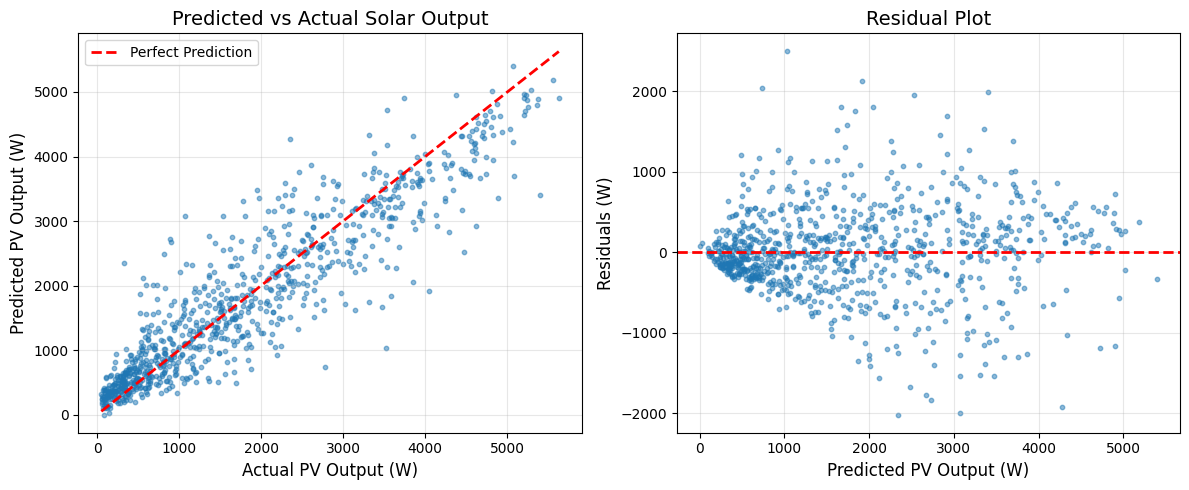

In [52]:
# Plot predicted vs actualplt.figure(figsize=(12, 5))# Scatter plotplt.subplot(1, 2, 1)plt.scatter(y_test_actual, y_pred_test, alpha=0.5, s=10)plt.plot([y_test_actual.min(), y_test_actual.max()],          [y_test_actual.min(), y_test_actual.max()],          'r--', linewidth=2, label='Perfect Prediction')plt.xlabel('Actual PV Output (W)', fontsize=12)plt.ylabel('Predicted PV Output (W)', fontsize=12)plt.title('Predicted vs Actual Solar Output', fontsize=14)plt.legend()plt.grid(True, alpha=0.3)# Residual plotplt.subplot(1, 2, 2)residuals = y_test_actual - y_predplt.scatter(y_pred_test, residuals, alpha=0.5, s=10)plt.axhline(y=0, color='r', linestyle='--', linewidth=2)plt.xlabel('Predicted PV Output (W)', fontsize=12)plt.ylabel('Residuals (W)', fontsize=12)plt.title('Residual Plot', fontsize=14)plt.grid(True, alpha=0.3)plt.tight_layout()plt.show()

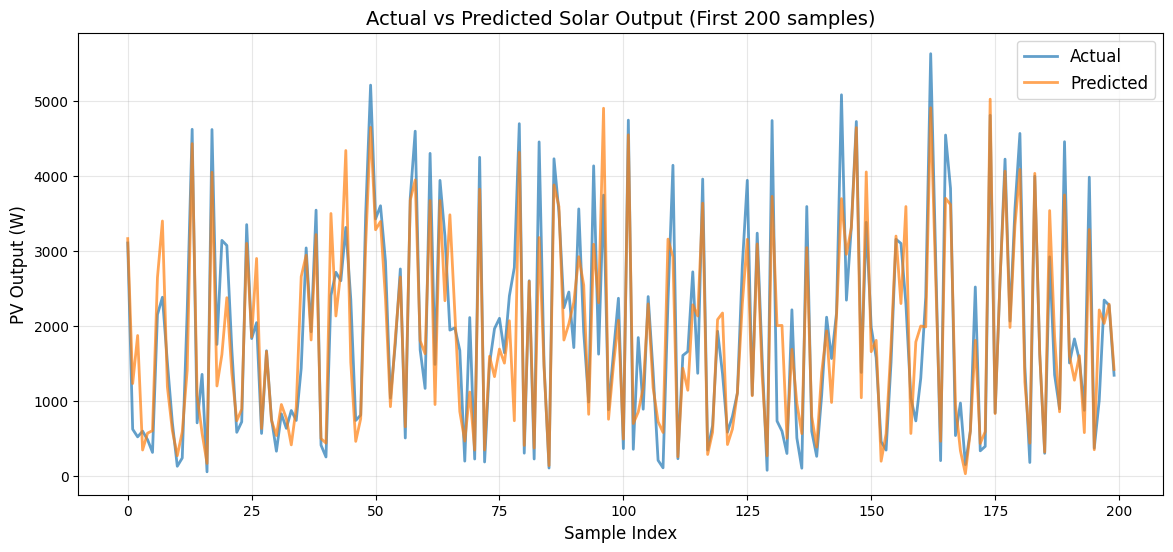

In [53]:
# Plot a sample of predictions vs actual over timen_samples = min(200, len(y_test_actual))plt.figure(figsize=(14, 6))plt.plot(range(n_samples), y_test_actual[:n_samples],          label='Actual', linewidth=2, alpha=0.7)plt.plot(range(n_samples), y_pred_test[:n_samples],          label='Predicted', linewidth=2, alpha=0.7)plt.xlabel('Sample Index', fontsize=12)plt.ylabel('PV Output (W)', fontsize=12)plt.title('Actual vs Predicted Solar Output (First 200 samples)', fontsize=14)plt.legend(fontsize=12)plt.grid(True, alpha=0.3)plt.show()

In [54]:
# Save the modelmodel_path = f"{MODEL_DIR}/pytorch_ann_model.pth"torch.save({    'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),    'scaler_X': scaler_X,    'scaler_y': scaler_y,    'feature_cols': feature_cols,    'target_col': target_col,    'train_losses': train_losses,    'test_losses': test_losses,    'metrics': {        'mae': mae,        'rmse': rmse,        'r2': r2,        'n_mae': n_mae,        'n_rmse': n_rmse    }}, model_path)print(f"Model saved to: {model_path}")

Model saved to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/model//pytorch_ann_model.pth


## Summary

This notebook demonstrates a simple PyTorch Artificial Neural Network (ANN) for predicting solar output (PV in Watts).

### Model Architecture:
- Input Layer: Variable size based on features
- Hidden Layer 1: 128 neurons with ReLU activation
- Hidden Layer 2: 64 neurons with ReLU activation
- Hidden Layer 3: 32 neurons with ReLU activation
- Output Layer: 1 neuron (regression output)
- Dropout: 0.2 for regularization

### Training Configuration:
- Optimizer: Adam with learning rate 0.001
- Loss Function: Mean Squared Error (MSE)
- Batch Size: 64
- Epochs: 200

### Key Features:
- Uses same features as the KAN model for fair comparison
- Includes weather features (temperature, humidity, wind, etc.)
- Incorporates temporal features (time of day, day of year, month)
- Uses clear sky power output as an important predictor

The model can be used for real-time solar output prediction and energy forecasting.